<a href="https://colab.research.google.com/github/EmilioJimenezL/Tarea2IA/blob/main/Tarea2WarehouseEnviroment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Episodio 100/1000 - Recompensa total: -130
Episodio 200/1000 - Recompensa total: -335
Episodio 300/1000 - Recompensa total: -245
Episodio 400/1000 - Recompensa total: -87
Episodio 500/1000 - Recompensa total: -73
Episodio 600/1000 - Recompensa total: -150
Episodio 700/1000 - Recompensa total: -250
Episodio 800/1000 - Recompensa total: -40
Episodio 900/1000 - Recompensa total: -221
Episodio 1000/1000 - Recompensa total: -170


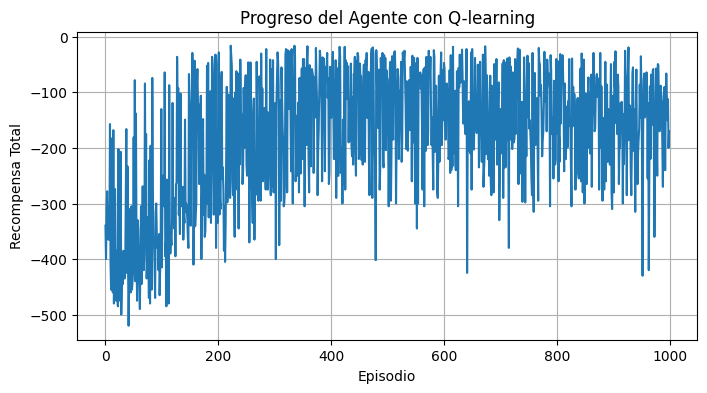

Mejor recompensa acumulada (global): -16


Mejor recompensa en episodio con entrega: -145


In [6]:
# Instalar gymnasium si aún no lo tienes instalado
!pip install gymnasium

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import random
from collections import defaultdict
from IPython.display import HTML

# =========================
# Definición del Entorno del Almacén con Múltiples Puntos
# =========================

class WarehouseEnv(gym.Env):
    def __init__(self):
        super(WarehouseEnv, self).__init__()
        self.grid_size = 10
        # Acciones: 0: Arriba, 1: Abajo, 2: Izquierda, 3: Derecha, 4: Pick, 5: Drop
        self.action_space = spaces.Discrete(6)

        # Estado:
        # - position: Coordenadas (x,y) del robot.
        # - item_status: 0 (sin ítem) o 1 (con ítem).
        # - energy: Nivel de energía (inicia en 100 y se reduce con cada acción).
        self.observation_space = spaces.Dict({
            'position': spaces.Box(low=0, high=self.grid_size-1, shape=(2,), dtype=np.int32),
            'item_status': spaces.Discrete(2),
            'energy': spaces.Box(low=0, high=100, shape=(1,), dtype=np.int32)
        })

        # Definir obstáculos (agrega todas las coordenadas que desees)
        self.obstacles = [(3, 3), (0, 9), (7, 5)]

        # Puntos de recogida: (para este ejemplo, dejamos uno, pero puedes hacerlo una lista)
        self.pickup_points = [(0, 0)]
        # Puntos de entrega: ahora es una lista de coordenadas
        self.delivery_points = [(7, 7), (6, 3)]

        self.reset()

    def reset(self, seed=None, options=None):
        # Estado inicial: robot en la esquina superior izquierda, sin ítem, con energía completa.
        self.robot_pos = [0, 0]
        self.item_status = 0
        self.energy = 100
        return self._get_obs(), {}

    def step(self, action):
        reward = -1  # Penalización base por cada paso
        done = False
        info = {}
        new_pos = self.robot_pos.copy()

        if action == 0:  # Arriba
            new_pos[1] -= 1
        elif action == 1:  # Abajo
            new_pos[1] += 1
        elif action == 2:  # Izquierda
            new_pos[0] -= 1
        elif action == 3:  # Derecha
            new_pos[0] += 1
        elif action == 4:  # Pick: Recoger ítem
            # Verifica si está en alguno de los puntos de recogida y no tiene ítem
            if tuple(self.robot_pos) in self.pickup_points and self.item_status == 0:
                self.item_status = 1
            else:
                reward -= 5
        elif action == 5:  # Drop: Entregar ítem
            # Verifica si está en alguno de los puntos de entrega y tiene el ítem
            if tuple(self.robot_pos) in self.delivery_points and self.item_status == 1:
                self.item_status = 0  # Se entrega y se pierde el ítem
                reward += 10
                info["delivery_successful"] = True
            else:
                reward -= 5
                info["delivery_successful"] = False

        if action in [0, 1, 2, 3]:
            if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
                if tuple(new_pos) in self.obstacles:
                    reward -= 10
                    done = True
                else:
                    self.robot_pos = new_pos
            else:
                reward -= 10

        self.energy -= 1
        if self.energy <= 0:
            reward -= 5
            done = True

        return self._get_obs(), reward, done, False, info

    def _get_obs(self):
        return {
            'position': np.array(self.robot_pos, dtype=np.int32),
            'item_status': self.item_status,
            'energy': np.array([self.energy], dtype=np.int32)
        }

    def render_graphical(self):
        """Visualización estática del entorno."""
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(np.arange(0, self.grid_size+1, 1))
        ax.set_yticks(np.arange(0, self.grid_size+1, 1))
        ax.grid(True)
        ax.invert_yaxis()

        # Obstáculos
        for obs in self.obstacles:
            rect = patches.Rectangle((obs[0], obs[1]), 1, 1, facecolor='gray', edgecolor='black')
            ax.add_patch(rect)
        # Puntos de recogida
        for pickup in self.pickup_points:
            rect = patches.Rectangle((pickup[0], pickup[1]), 1, 1,
                                     facecolor='blue', edgecolor='black', alpha=0.5)
            ax.add_patch(rect)
        # Puntos de entrega
        for delivery in self.delivery_points:
            rect = patches.Rectangle((delivery[0], delivery[1]), 1, 1,
                                     facecolor='red', edgecolor='black', alpha=0.5)
            ax.add_patch(rect)
        # Robot
        rect = patches.Rectangle((self.robot_pos[0], self.robot_pos[1]), 1, 1,
                                 facecolor='green', edgecolor='black')
        ax.add_patch(rect)

        ax.set_title("Entorno del Almacén")
        plt.show()

# =========================
# Función Auxiliar para Convertir el Estado a Tupla
# =========================

def state_to_tuple(state):
    pos = state['position']
    item_status = state['item_status']
    energy = int(state['energy'][0])
    return (int(pos[0]), int(pos[1]), item_status, energy)


# =========================
# Q-learning y Entrenamiento (con registro de trayectoria que incluye contador de entregas)
# =========================

env = WarehouseEnv()
Q = defaultdict(lambda: np.zeros(env.action_space.n))

episodes = 1000
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

reward_list = []
best_reward = -np.inf
best_trajectory = None
best_episode = None

best_delivery_reward = -np.inf
best_delivery_trajectory = None
best_delivery_episode = None

for episode in range(episodes):
    state, _ = env.reset()
    state_tuple = state_to_tuple(state)
    done = False
    total_reward = 0
    delivery_counter = 0
    # Almacenamos tuplas: (posición, item_status, contador de entregas)
    episode_states = [(env.robot_pos.copy(), env.item_status, delivery_counter)]
    delivery_made = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state_tuple])

        next_state, reward, done, _, info = env.step(action)
        if info.get("delivery_successful", False):
            delivery_made = True
            delivery_counter += 1

        # Registrar el estado actual: posición, si carga un ítem y el contador de entregas
        episode_states.append((env.robot_pos.copy(), env.item_status, delivery_counter))
        next_state_tuple = state_to_tuple(next_state)

        best_next_action = np.argmax(Q[next_state_tuple])
        td_target = reward + gamma * Q[next_state_tuple][best_next_action]
        td_error = td_target - Q[state_tuple][action]
        Q[state_tuple][action] += alpha * td_error

        state_tuple = next_state_tuple
        total_reward += reward

    if total_reward > best_reward:
        best_reward = total_reward
        best_trajectory = episode_states
        best_episode = episode + 1

    if delivery_made and total_reward > best_delivery_reward:
        best_delivery_reward = total_reward
        best_delivery_trajectory = episode_states
        best_delivery_episode = episode + 1

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    reward_list.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"Episodio {episode+1}/{episodes} - Recompensa total: {total_reward}")

plt.figure(figsize=(8,4))
plt.plot(reward_list)
plt.xlabel("Episodio")
plt.ylabel("Recompensa Total")
plt.title("Progreso del Agente con Q-learning")
plt.grid(True)
plt.show()

# =========================
# Visualización Animada
# =========================

def animate_episode(episode_states, env, title="Episodio", attempt_num = None):
    """Crea una animación mostrando la trayectoria, el contador de entregas y una etiqueta
       'Cargando' cuando el robot lleva un ítem."""
    fig, ax = plt.subplots(figsize=(6,6))

    def init():
        ax.clear()
        ax.set_xlim(0, env.grid_size)
        ax.set_ylim(0, env.grid_size)
        ax.set_xticks(np.arange(0, env.grid_size+1, 1))
        ax.set_yticks(np.arange(0, env.grid_size+1, 1))
        ax.grid(True)
        ax.invert_yaxis()
        return []

    def update(frame):
        ax.clear()
        ax.set_xlim(0, env.grid_size)
        ax.set_ylim(0, env.grid_size)
        ax.set_xticks(np.arange(0, env.grid_size+1, 1))
        ax.set_yticks(np.arange(0, env.grid_size+1, 1))
        ax.grid(True)
        ax.invert_yaxis()

        # Dibujar obstáculos
        for obs in env.obstacles:
            rect = patches.Rectangle((obs[0], obs[1]), 1, 1, facecolor='gray', edgecolor='black')
            ax.add_patch(rect)
        # Dibujar todos los puntos de recogida
        for pickup in env.pickup_points:
            rect = patches.Rectangle((pickup[0], pickup[1]), 1, 1, facecolor='blue', edgecolor='black', alpha=0.5)
            ax.add_patch(rect)
        # Dibujar todos los puntos de entrega
        for delivery in env.delivery_points:
            rect = patches.Rectangle((delivery[0], delivery[1]), 1, 1, facecolor='red', edgecolor='black', alpha=0.5)
            ax.add_patch(rect)

        # Extraer datos del estado actual: (posición, item_status, contador de entregas)
        robot_pos, item_status, delivery_count = episode_states[frame]
        rect = patches.Rectangle((robot_pos[0], robot_pos[1]), 1, 1, facecolor='green', edgecolor='black')
        ax.add_patch(rect)

        # Mostrar contador de entregas en una posición fija del gráfico
        ax.text(0, -0.5, f"Entregas exitosas: {delivery_count}", fontsize=12, color='black')

        # Si el robot está cargando un ítem, mostrar la etiqueta "Cargando" cerca del robot
        if item_status == 1:
            ax.text(robot_pos[0], robot_pos[1]-0.3, "Cargando", fontsize=10, color='purple')

        # Incluir el número del intento en el título si se pasó el parámetro
        attempt_text = f" - Intento #{attempt_num}" if attempt_num is not None else ""
        ax.set_title(f"{title}{attempt_text} - Paso {frame+1}/{len(episode_states)}")
        return []

        ax.set_title(f"{title} - Paso {frame+1}/{len(episode_states)}")
        return []

    anim = animation.FuncAnimation(fig, update, frames=len(episode_states), init_func=init, interval=300, blit=True)
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

# Visualizar el mejor episodio global (por recompensa total)
if best_trajectory is not None:
    print(f"Mejor recompensa acumulada (global): {best_reward}")
    display(animate_episode(best_trajectory, env, title="Mejor Episodio (Global)", attempt_num = best_episode))
else:
    print("No se encontró una trayectoria válida.")

# Visualizar un episodio en el que se realizó al menos una entrega exitosa (si existe)
if best_delivery_trajectory is not None:
    print(f"Mejor recompensa en episodio con entrega: {best_delivery_reward}")
    display(animate_episode(best_delivery_trajectory, env, title="Episodio con Entrega", attempt_num = best_delivery_episode))
else:
    print("No se encontró ningún episodio con entrega exitosa.")
